# Exercise 17


In [1]:
import pandas as pd
train_df = pd.read_csv('14_mashable_train_df.csv', index_col=0)
train_df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2013/09/16/sprints-upgrade...,479,11,1045,0.407946,1,0.617021,29,3,1,...,0.033333,1.0,-0.305139,-0.700000,-0.125000,0.0,0.0,0.5,0.0,1
1,http://mashable.com/2014/12/06/eric-garner-pro...,31,14,0,0.000000,0,0.000000,0,0,0,...,0.000000,0.0,0.000000,0.000000,0.000000,1.0,-0.5,0.5,0.5,0
2,http://mashable.com/2013/06/06/human-scale-inv...,581,6,604,0.470000,1,0.675516,9,0,1,...,0.100000,1.0,-0.215873,-0.666667,-0.071429,0.1,0.0,0.4,0.0,0
3,http://mashable.com/2014/11/24/beyonce-spotify...,44,16,708,0.474286,1,0.675325,5,2,2,...,0.062500,0.5,-0.376852,-0.875000,-0.100000,0.4,-0.2,0.1,0.2,0
4,http://mashable.com/2013/03/03/superheroic-let...,676,7,30,1.000000,1,1.000000,2,1,0,...,0.250000,0.7,0.000000,0.000000,0.000000,0.0,0.0,0.5,0.0,1


In [2]:
train_df.shape

(23786, 61)

In [3]:
X = train_df.drop(['url', 'Popular'], axis=1)
y = train_df['Popular']

In [4]:
# train/test split
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Exercice 17.1 (2 points)

Estimate 600 bagged samples

Estimate the following set of classifiers:

* 100 Decision Trees where max_depth=None
* 100 Decision Trees where max_depth=2
* 100 Decision Trees using an under-sampled dataset where max_depth=None
* 100 Decision Trees using an under-sampled dataset where max_depth=2
* 100 GaussianNB
* 100 GaussianNB using an under-sampled dataset

**note:** the under-sampled set is estimated from the bagged samples, i.e., each under-sampled set is different

In [5]:
import numpy as np
# set a seed for reproducibility
np.random.seed(123)

n_samples = X_train.shape[0]
n_B=600
# create bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1,n_B+1)]

In [7]:
from sklearn.tree import DecisionTreeClassifier

models=[]
for j in range(100):
    models.append(DecisionTreeClassifier(max_depth=None))
    models[j].fit(X_train.iloc[samples[j]],y_train.iloc[samples[j]])

In [8]:
for j in range(100,200):
    models.append(DecisionTreeClassifier(max_depth=2))
    models[j].fit(X_train.iloc[samples[j]],y_train.iloc[samples[j]])

In [9]:
def UnderSampling(X, y, target_percentage=0.5, seed=None):
    # Assuming minority class is the positive
    n_samples = y.shape[0]
    n_samples_0 = (y == 0).sum()
    n_samples_1 = (y == 1).sum()

    n_samples_0_new =  n_samples_1 / target_percentage - n_samples_1
    n_samples_0_new_per = n_samples_0_new / n_samples_0

    filter_ = y == 0

    np.random.seed(seed)
    rand_1 = np.random.binomial(n=1, p=n_samples_0_new_per, size=n_samples)
    
    filter_ = filter_ & rand_1
    filter_ = filter_ | (y == 1)
    filter_ = filter_.astype(bool)
    
    return X[filter_], y[filter_]

In [10]:
for j in range(200,300):
    X_u,y_u = UnderSampling (X_train.iloc[samples[j]],y_train.iloc[samples[j]],
                            target_percentage=0.5,seed=j) 
    
    models.append(DecisionTreeClassifier(max_depth=None))
    models[j].fit(X_u, y_u)

In [11]:
for j in range(300,400):
    X_u,y_u = UnderSampling (X_train.iloc[samples[j]],y_train.iloc[samples[j]],
                            target_percentage=0.5,seed=j) 
    
    models.append(DecisionTreeClassifier(max_depth=2))
    models[j].fit(X_u, y_u)

In [12]:
from sklearn.naive_bayes import GaussianNB

for j in range(400,500):
    models.append(GaussianNB())
    models[j].fit(X_train.iloc[samples[j]],y_train.iloc[samples[j]])


In [14]:
for j in range(500, 600):
    X_u,y_u = UnderSampling(X_train.iloc[samples[j]], y_train.iloc[samples[j]],
                            target_percentage=0.5, seed=j)
        
    models.append(GaussianNB())
    models[j].fit(X_u,y_u)

In [13]:
len(models)

600

# Exercice 17.2 

Ensemble using majority voting

Evaluate using the following metrics:
* Accuracy
* F1-Score
* F_Beta-Score (Beta=2)

In [16]:
import pandas as pd
y_predict_all = pd.DataFrame(index=X_test.index)

In [17]:
for t in range(600):
    y_predict_all['M' + str(t)]=models[t].predict(X_test)

In [18]:
y_predict_all.head()

,M0,M1,M2,M3,M4,M5,M6,M7,M8,M9,...,M590,M591,M592,M593,M594,M595,M596,M597,M598,M599
8861,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
17184,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
20505,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11503,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
22682,1,0,1,0,0,0,0,1,0,0,...,1,1,1,1,1,1,1,1,1,1


In [19]:
y_pred=(y_predict_all.sum(axis=1)>=300).astype(int)
y_pred.head()

8861     0
17184    0
20505    0
11503    0
22682    1
dtype: int32

In [20]:
from sklearn.metrics import accuracy_score, f1_score, fbeta_score
def results(y_pred,y_test):
    f1 = f1_score(y_test,y_pred) 
    acc = accuracy_score(y_test,y_pred)
    fbeta = fbeta_score(y_test,y_pred,beta=2)
    
    return acc,f1,fbeta

In [21]:
results(y_pred,y_test)

(0.84546830334622503, 0.21787234042553189, 0.17917133258678611)

# Exercice 17.3

Estimate te probability as %models that predict positive

Modify the probability threshold and select the one that maximizes the fbeta_score

In [22]:
y_pred_proba = y_predict_all.sum(axis=1) / 600
y_pred_proba.head()

8861     0.318333
17184    0.120000
20505    0.031667
11503    0.218333
22682    0.573333
dtype: float64

In [23]:
y_pred=(y_pred_proba>=0.01).astype(int)
results(y_pred,y_test)

(0.13519421557087608, 0.2370568164960688, 0.43718537973298316)

In [24]:
res = []
thresholds = np.arange(0, 1, 0.01)

for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    res.append(fbeta_score(y_test,y_pred,2))

C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


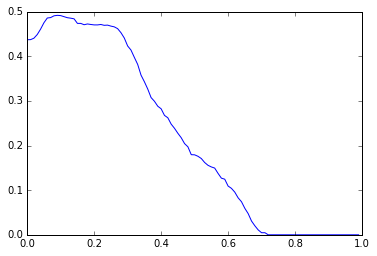

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(thresholds,res)

In [26]:
np.max(res)

0.49163486938655698

In [27]:
np.argmax(res)

9

In [28]:
thresholds[9]

0.089999999999999997

In [29]:
y_pred = (y_pred_proba >= 0.089999999999999997).astype(int)
results(y_pred,y_test)

(0.48259626702539093, 0.30337333031469321, 0.49163486938655698)

# Exercice 17.4 (2 points)

Ensemble using Weighted Voting

Calculate the weight using the oob error

In [30]:
samples_oob = []
# show the "out-of-bag" observations for each sample
for sample in samples:
    samples_oob.append(sorted(set(range(n_samples)) - set(sample)))

In [31]:
errors = np.zeros(600)
for i in range(600):
    y_pred_ = models[i].predict(X_train.iloc[samples_oob[i]])
    errors[i] = 1 - accuracy_score(y_train.iloc[samples_oob[i]], y_pred_)

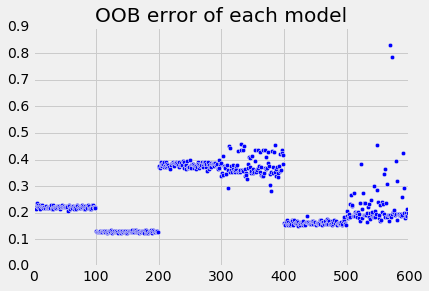

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

plt.scatter(range(600), errors)
plt.xlim([0, 600])
plt.title('OOB error of each model')

In [33]:
alpha = (1 - errors) / (1 - errors).sum()

In [34]:
weighted_sum_1 = ((y_predict_all) * alpha).sum(axis=1)

In [35]:
weighted_sum_1.head(5)

8861     0.274142
17184    0.097494
20505    0.024495
11503    0.180703
22682    0.562671
dtype: float64

# Exercice 17.5

Estimate te probability of the weighted voting

Modify the probability threshold and select the one that maximizes the fbeta_score

In [36]:
y_pred = (weighted_sum_1 >= 0.5).astype(np.int)

results(y_pred, y_test)

(0.84883134353455525, 0.19946571682991984, 0.15909090909090909)

In [37]:
res = []
thresholds = np.arange(0, 1, 0.01)

for threshold in thresholds:
    y_pred = (weighted_sum_1 >= threshold).astype(np.int)
    res.append(fbeta_score(y_test,y_pred,2))

C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


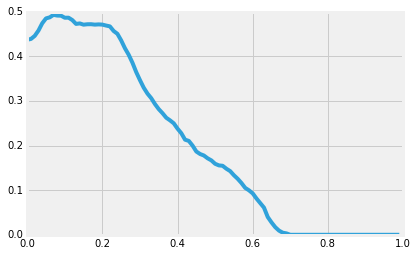

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(thresholds,res)

In [39]:
np.max(res)

0.49269550272128332

In [40]:
np.argmax(res)

7

In [41]:
thresholds[7]

0.070000000000000007

In [42]:
y_pred = (y_pred_proba >= thresholds[7]).astype(int)
results(y_pred,y_test)

(0.402555910543131, 0.28811861350430773, 0.48659989171629675)

# Exercice 17.6 (2 points)

Estimate a logistic regression using as input the estimated classifiers

Modify the probability threshold such that maximizes the fbeta_score

In [43]:
y_predict_train = pd.DataFrame(index=X_train.index)

In [44]:
for t in range(600):
    y_predict_train['M_'+str(t)] = models[t].predict(X_train)
y_predict_train.head()

,M_0,M_1,M_2,M_3,M_4,M_5,M_6,M_7,M_8,M_9,...,M_590,M_591,M_592,M_593,M_594,M_595,M_596,M_597,M_598,M_599
5510,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19828,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
851,0,0,0,0,0,0,1,0,0,0,...,1,1,1,1,1,1,1,1,1,1
9434,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
7569,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [45]:
from sklearn.linear_model import LogisticRegression
clf =LogisticRegression()
clf.fit(y_predict_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [46]:
y_pred=clf.predict(y_predict_all)
results(y_pred,y_test)

(0.85168992769463592, 0.13017751479289941, 0.096745822339489876)

In [47]:
y_predict_proba =clf.predict_proba(y_predict_all)[:,1]

In [48]:
y_pred = (y_predict_proba >= 0.3).astype(int)
results(y_pred,y_test)

(0.84546830334622503, 0.15919487648673375, 0.12464183381088827)

In [49]:
res = []
thresholds = np.arange(0, 0.01, 0.00001)

for threshold in thresholds:
    y_pred = (y_predict_proba >= threshold).astype(np.int)
    res.append(fbeta_score(y_test,y_pred,2))

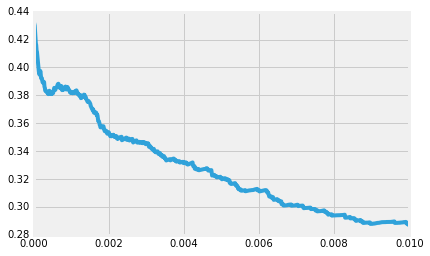

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(thresholds,res)

In [51]:
np.max(res)

0.43694629771409826

In [52]:
np.argmax(res)

0

In [53]:
y_pred = (y_pred_proba >= thresholds[0]).astype(int)
results(y_pred,y_test)

(0.13435345552379352, 0.23688111473465759, 0.43694629771409826)

# Exercice 17.7 (2 points)

Estimate a AdaBoostClassifier and a GradientBoostingClassifier using the training and an under-sampled set

In [54]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [55]:
X_u,y_u = UnderSampling (X_train,y_train,
                      target_percentage=0.5, seed=42)

In [56]:
clf = AdaBoostClassifier()
clf.fit(X_u,y_u)
y_pred = clf.predict(X_test)
results(y_pred,y_test)

(0.65158903648898603, 0.33928571428571425, 0.4807518525212362)

In [57]:
clf = GradientBoostingClassifier()
clf.fit(X_u, y_u)
y_pred = clf.predict(X_test)
results(y_pred,y_test)

(0.64419034807465947, 0.34163036714374612, 0.48921760826947075)

In [58]:
clf = GradientBoostingClassifier()
clf.fit(X_test, y_test)
y_pred_proba =clf.predict_proba(X_test)[:,1]

In [59]:
res = []
thresholds = np.arange(0, 1, 0.01)

for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(np.int)
    res.append(fbeta_score(y_test,y_pred,2))

C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


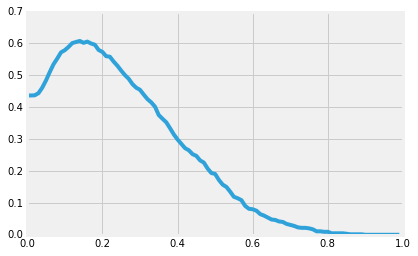

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(thresholds,res)

In [61]:
np.max(res)

0.6079115764979639

In [62]:
np.argmax(res)

14

In [63]:
y_pred = (y_pred_proba >= thresholds[14]).astype(int)
results(y_pred,y_test)

(0.74676307381873208, 0.45434782608695651, 0.6079115764979639)

# Bonus: Exercice 18.8 (4 points)

Estimate 3 ensembles of the 600 models
* Average the probabilities
* Average the weighted probabilities
* Learn a logistic regression using the probabilities

For each select the threshold that maximizes the fbeta_score

In [64]:
y_predict_all_proba=pd.DataFrame(index=X_test.index)

In [65]:
for t in range(600):
    y_predict_all_proba['M_' + str(t) ]= models[t].predict_proba(X_test)[:,1]

In [66]:
y_predict_all_proba.head()

,M_0,M_1,M_2,M_3,M_4,M_5,M_6,M_7,M_8,M_9,...,M_590,M_591,M_592,M_593,M_594,M_595,M_596,M_597,M_598,M_599
8861,0,1,0,0,0,0,0,0,1,0,...,0.282825,0.218501,0.171399,0.333834,0.014013,0.058892,0.223999,0.025882,0.436953,0.019965
17184,0,0,0,0,0,0,0,0,0,0,...,0.584409,0.400035,0.109771,0.045628,0.094990,0.139459,0.199850,0.152053,0.072050,0.104448
20505,0,0,0,0,0,0,0,0,0,0,...,0.391370,0.245885,0.049030,0.018694,0.056189,0.076801,0.112470,0.067930,0.035365,0.043835
11503,0,0,0,0,0,0,0,0,0,0,...,0.610436,0.388221,0.117455,0.044593,0.093945,0.112636,0.181582,0.131255,0.057464,0.060368
22682,1,0,1,0,0,0,0,1,0,0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [67]:
y_pred = (y_predict_all_proba.sum(axis=1) >= 300).astype(int)
y_pred.head()

8861     0
17184    0
20505    0
11503    0
22682    1
dtype: int32

In [68]:
from sklearn.metrics import accuracy_score, f1_score, fbeta_score
def results(y_pred,y_test):
    f1 = f1_score(y_test,y_pred) 
    acc = accuracy_score(y_test,y_pred)
    fbeta = fbeta_score(y_test,y_pred,beta=2)
    
    return acc,f1,fbeta

In [69]:
results(y_pred,y_test)

(0.84799058348747269, 0.21799307958477507, 0.17731494511680271)

In [70]:
y_pred_proba = y_predict_all_proba.sum(axis=1) / 600
y_pred_proba.head()

8861     0.294022
17184    0.190333
20505    0.109393
11503    0.205786
22682    0.548626
dtype: float64

In [71]:
y_pred = (y_pred_proba >= 0.01).astype(int)
results(y_pred,y_test)

(0.13435345552379352, 0.23688111473465759, 0.43694629771409826)

In [72]:
res = []
thresholds = np.arange(0, 1, 0.01)

for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    res.append(fbeta_score(y_test,y_pred,2))

C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [73]:
np.argmax(res)

20

In [74]:
y_pred = (y_pred_proba >= thresholds[20]).astype(int)
results(y_pred,y_test)

(0.55052967882966197, 0.31863369869997454, 0.49446202531645572)

## Average the weighted probabilities

In [75]:
samples_oob = []
# show the "out-of-bag" observations for each sample
for sample in samples:
    samples_oob.append(sorted(set(range(n_samples)) - set(sample)))

In [76]:
errors = np.zeros(600)

for i in range(600):
    y_pred_ = models[i].predict(X_train.iloc[samples_oob[i]])
    errors[i] = 1 - accuracy_score(y_train.iloc[samples_oob[i]], y_pred_)

In [77]:
alpha = (1 - errors) / (1 - errors).sum()

In [78]:
weighted_sum_1 = ((y_predict_all_proba) * alpha).sum(axis=1)

In [79]:
y_pred = (weighted_sum_1 >= 0.5).astype(np.int)

results(y_pred,y_test)

(0.84933579956280481, 0.19999999999999998, 0.1592266135911288)

In [80]:
res = []
thresholds = np.arange(0, 1, 0.01)

for threshold in thresholds:
    y_pred = (weighted_sum_1 >= threshold).astype(np.int)
    res.append(fbeta_score(y_test,y_pred,2))

C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [81]:
np.argmax(res)

18

In [82]:
y_pred = (y_pred_proba >= thresholds[18]).astype(int)
results(y_pred,y_test)

(0.48932234740205144, 0.30551109078435862, 0.49335302806499259)

## Learn a logistic regression using the probabilities

In [83]:
for t in range(600):
    y_predict_train['M_'+str(t)] = models[t].predict_proba(X_train)
y_predict_train.head()

,M_0,M_1,M_2,M_3,M_4,M_5,M_6,M_7,M_8,M_9,...,M_590,M_591,M_592,M_593,M_594,M_595,M_596,M_597,M_598,M_599
5510,1,1,1,1,1,1,1,1,1,1,...,0.617594,0.757493,0.942250,0.980660,0.934974,0.927073,0.873377,0.936450,0.958573,0.951096
19828,1,1,1,1,1,1,1,1,1,1,...,0.605048,0.753126,0.942243,0.972587,0.942573,0.921729,0.856717,0.931508,0.959392,0.951583
851,1,1,1,1,1,1,0,1,1,1,...,0.004319,0.016479,0.000216,0.000885,0.001011,0.027534,0.000258,0.018694,0.000034,0.006223
9434,1,1,1,1,1,1,1,1,1,1,...,0.317874,0.271381,0.798927,0.929589,0.741376,0.701535,0.613236,0.659905,0.730238,0.846069
7569,0,1,0,0,0,0,0,0,0,0,...,0.020734,0.051925,0.012654,0.031198,0.030817,0.104514,0.010127,0.083637,0.004422,0.044846


In [84]:
from sklearn.linear_model import LogisticRegression 
clf = LogisticRegression()
clf.fit(y_predict_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [85]:
y_pred = clf.predict(y_predict_all_proba)
results(y_pred,y_test)

(0.75197578611064397, 0.034053700065487885, 0.033129459734964319)

In [86]:
y_predict_proba = clf.predict_proba(y_predict_all_proba)[:, 1]

In [87]:
y_pred = (y_predict_proba >= 0.3).astype(int)
results(y_pred,y_test)

(0.67513031780729782, 0.041666666666666657, 0.047586675730795377)

In [88]:
res = []
thresholds = np.arange(0, 0.01, 0.00001)

for threshold in thresholds:
    y_pred = (y_predict_proba >= threshold).astype(np.int)
    res.append(fbeta_score(y_test,y_pred,2))

In [89]:
np.argmax(res)

0

In [90]:
y_pred = (y_pred_proba >= thresholds[0]).astype(int)
results(y_pred,y_test)

(0.13435345552379352, 0.23688111473465759, 0.43694629771409826)